# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'#supress info warnings

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns


import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "EuroSAT" # replace with your path

^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [3]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    ## load images and labels
    # FILL IN CODE HERE #  

    #initializing list to store images and labels
    images=[]
    labels = []

    #get list of all folders each reprenting a class
    classes = os.listdir(path_to_data)

    #loop through each class folder
    for class_label in classes:
        class_folder = os.path.join(path_to_data, class_label)

        #get a list of all images in the class folder
        images_filenames = os.listdir(class_folder)

        #loop through each image file
        for image_filename in tqdm(images_filenames):
            #build full image path
            image_path = os.path.join(class_folder, image_filename)

            #load image, resizing and convert it to array
            image = load_img(image_path, target_size=(64,64))
            image_array = img_to_array(image)

            #append image array and the corresponding label
            images.append(image_array)
            labels.append(class_label)
    
    #convert list to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [4]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:02<00:00, 1487.00it/s]


Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced? `**No they are not.** `

Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why? `**Plotting the distribution of the classes before splitting the data into training, validation, and test sets is acceptable because we are not looking at individual samples or labels from the test set. We are only observing the overall distribution of the labels in the dataset. This distribution is a global property of the dataset and does not provide any information about the specific instances in the test set. The "blindness" of the test set refers to avoiding exposure to the actual samples in the test set during training, which remains intact.**`

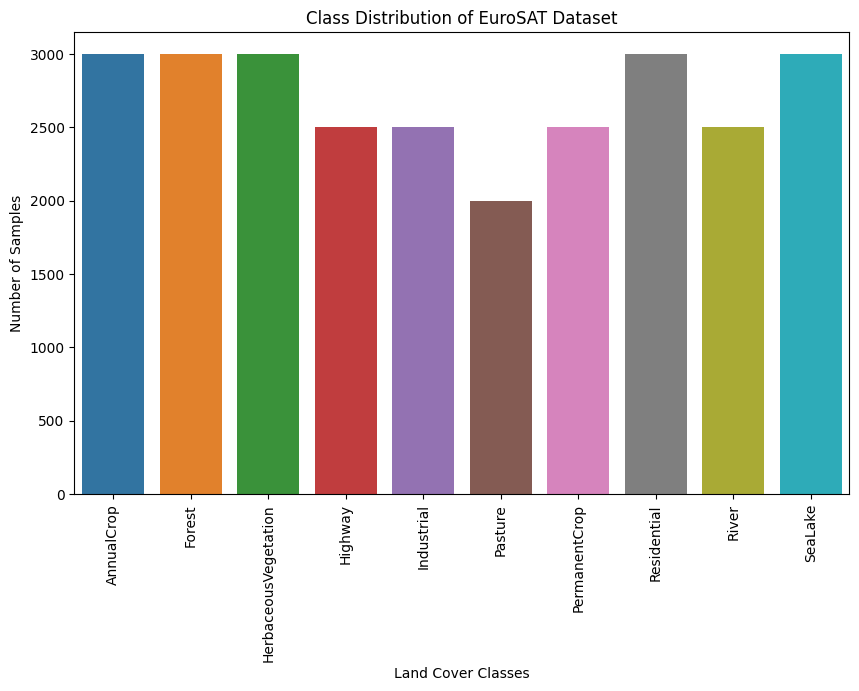

In [5]:
# FILL IN CODE HERE # 
#first encode labels from string to numerical
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

#get unique classes and count
unique_classes, counts = np.unique(labels, return_counts = True)

#plotting the class distribution
plt.figure(figsize = (10,6))
sns.barplot(x = unique_classes, y = counts)
plt.xticks(rotation = 90)
plt.xlabel("Land Cover Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of EuroSAT Dataset")
plt.show()

Comment on class balance: [`based on the dstribution plot, the classes in the dataset are relatively balanced, with most classes having around 2500 to 3000 samples. There is a slight underrepresentation in the Pasture class with 2000 samples.`]

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

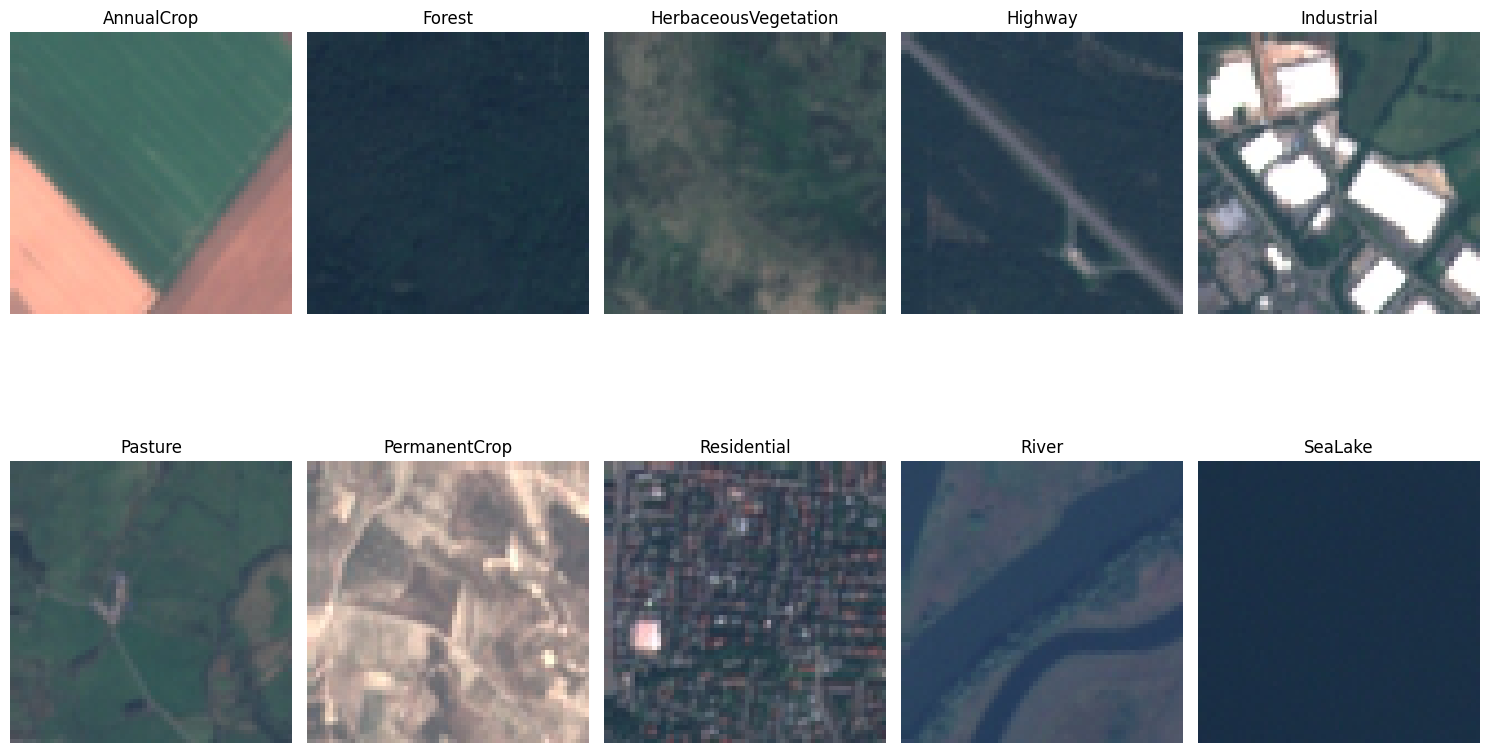

In [6]:
# FILL IN CODE HERE #

plt.figure(figsize = (15, 10))

#loop through each unique class
for i, class_label in enumerate(unique_classes):
    #find the index of the first image that belongs to the current class
    index = np.where(labels == class_label)[0][0]

    #get the corresponding image
    image = images[index]

    #plotting
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype("uint8")) #to display the image correctly
    plt.title(class_label)
    plt.axis("off")

#display the plot
plt.tight_layout()
plt.show()

Most confused land classes: [`Forest and HerbaceousVegetaion because these two classes share similar textural and color features. The satellite images for both classes may show a dense green pattern with little distinct structure, making it challenging for a decision tree to differentiate based on pixel values alone. Since decision trees split the data by creating boundaries based on features (pixel intensities in this case), the similarity in the distribution of colors and textures might cause confusion between these two classes. Another possible class confusion could River and SeaLake since both classes represnt large bodies of water. If the Rivers are wide, there could some issue deciding between the two. Another class for possible confusion is Forest and SeaLake as the SeaLake image shows dark water that could be mistaken for darker areas in the Forest.`]

---
### Step 3: Data preprocessing

Encode labels

In [7]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [8]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    # FILL IN CODE HERE #
    indices = np.arange(len(images))  # create an array of indices
    np.random.shuffle(indices)  # shuffle the indices
    images_shuffled = images[indices]  # shuffle images based on the shuffled indices
    labels_shuffled = labels[indices]  # shuffle labels accordingly
    
    # Determine split indices
    total_count = len(images)
    train_size = int(split[0] * total_count)  # 60% for training
    val_size = int(split[1] * total_count)    # 20% for validation
    
    # create data splits
    # FILL IN CODE HERE #
    X_train, y_train = images_shuffled[:train_size], labels_shuffled[:train_size]
    X_val, y_val = images_shuffled[train_size:train_size + val_size], labels_shuffled[train_size:train_size + val_size]
    X_test, y_test = images_shuffled[train_size + val_size:], labels_shuffled[train_size + val_size:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [10]:
import gc
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3

    # Convert numpy arrays to TensorFlow tensors
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    
    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, delta = DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor = CONTRAST_FACTOR)

        # random flip left to right
        X_augm = tf.image.flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis = 0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor
        
        
    # normalize/rescale image by dividing each pixel by 255.0 
    # FILL IN CODE HERE #
    X = X / 255.0
    
    return X, y

Comment on the importnace of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): [`Data augmentation expands the size of the dataset and it's important because it improves the generalization of the model. It prevents overfitting by exposing the model to generalize beyond the specific examples in the training dataset. We don't augment on the validation and test sets because they are meant to provide unbiased assessment of the model's performance to unseen data. Their purpose is test how the model will perform in the real world and so, by augmenting the validation and test datasets, we will introduce variability that isn't present in real world scenarios.`]

In [11]:
# Enable Memory Growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(e)

#clear session
from tensorflow.keras import backend as K
K.clear_session()


#limit tensorflow's memory usage to 50%
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [12]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [13]:
# conversion back to numpy for non-training data as well
X_val = X_val.numpy()
X_test = X_test.numpy()

# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

Training Accuracy: 0.4781
Validation Accuracy: 0.4461


<Figure size 1000x800 with 0 Axes>

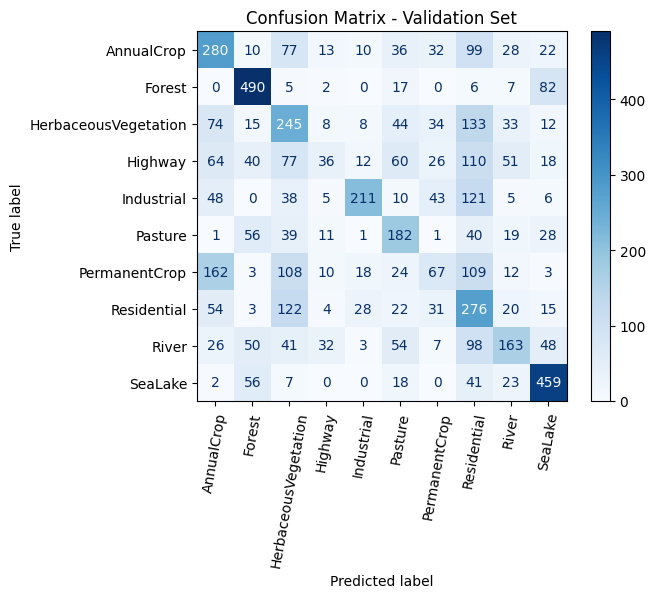

In [15]:
### YOUR CODE HERE ###
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier with the specified parameters
rf_classifier = RandomForestClassifier(n_estimators=2, max_depth=8, random_state=7, n_jobs=1)

# Train the model on training data
rf_classifier.fit(X_train_re, y_train)

# Predict on the training set
y_train_pred = rf_classifier.predict(X_train_re)

# Predict on the validation set
y_val_pred = rf_classifier.predict(X_val_re)

# Evaluate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print training and validation accuracies
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=encoded_labels_classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.xticks(rotation = 80)
plt.title("Confusion Matrix - Validation Set")
plt.show()

Does the model generalize well?: [`Given that the training accuracy is close to the validation accuracy, the model generalizes fairly consistently between the training and validation sets, although both accuracies are low. The fact that the gap between training and validation accuracy is small suggests that the model isn’t overfitting.`]

Comment on model accuracy on training vs. validation data: [`The training accuracy of the model is 0.4781, while the validation accuracy is 0.4461. The training accuracy is only marginally higher than the validation accuracy, which indicates that the model does not overfit heavily. However, both accuracies are relatively low - below 50%, suggesting that the model is struggling to accurately classify a significant portion of the data.`]

Comment on the classes that the model confuses the most: [`The greatest confusion in the model occurs between PermanentCrop and AnnualCrop, with 162 instances of PermanentCrop being misclassified as AnnualCrop. Following this, there is significant confusion between HerbaceousVegetation and Residential, where 133 instances of HerbaceousVegetation were classified as Residential, and 122 instances of Residential were misclassified as HerbaceousVegetation. Additionally, 110 instances of Highway were misclassified as Residential, and there were 109 instances where PermanentCrop was confused with Residential. Looking at the images, the confusion between PermanentCrop and AnnualCrop could stem from their similar patterns of organized fields and vegetation, making them hard to distinguish from an aerial view. The confusion between HerbaceousVegetation and Residential likely arises due to the presence of green spaces or vegetation in residential areas, which can appear visually similar to natural vegetation. Highway and Residential misclassifications may occur because highways often run through or near residential areas, with similar structural layouts and man-made features visible in both.`]

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines: 
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

Training Accuracy: 0.6202
Validation Accuracy: 0.5387


<Figure size 1000x800 with 0 Axes>

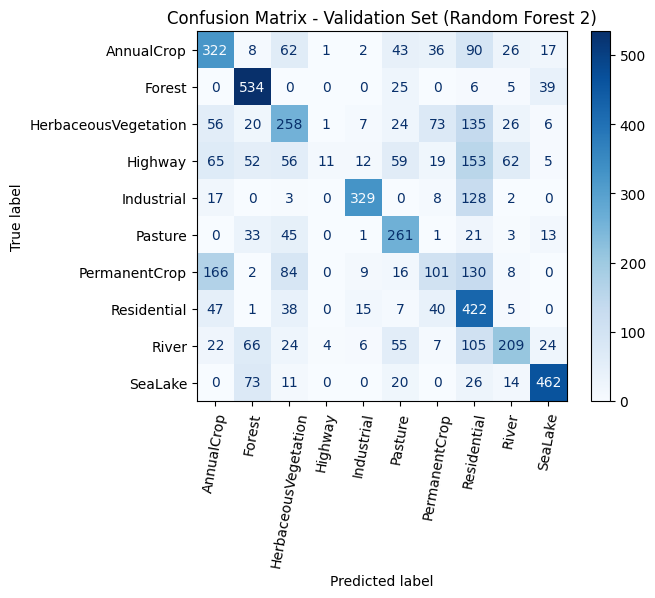

In [16]:
### YOUR CODE HERE ###
# Initialize the RandomForestClassifier with the specified parameters
rf_clf2 = RandomForestClassifier(n_estimators=30, max_depth=8,  random_state=7, n_jobs=-1)

# Train the model on training data
rf_clf2.fit(X_train_re, y_train)

# Predict on the training set
y_train_pred = rf_clf2.predict(X_train_re)

# Predict on the validation set
y_val_pred = rf_clf2.predict(X_val_re)

# Evaluate the model's accuracy on the training and validation data
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the training and validation accuracies
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Compute and plot the confusion matrix for the validation set
conf_matrix2 = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(conf_matrix2, display_labels=encoded_labels_classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.xticks(rotation=80)  # Rotate x-axis labels for better readability
plt.title("Confusion Matrix - Validation Set (Random Forest 2)")
plt.show()

How your implementation is different compared to the baseline classifier: [` The main difference between my implementation and the baseline model is the number of trees (n_estimators) used in the RandomForestClassifier. Baseline model uses 2 trees while my model uses 30 trees. The modification made in the second model improves the capacity of the model, allowing it to learn more detailed relationships between the features and labels, but increasing the max_depth=8 hyperparameter to anything over 8 leads to significant overfitting.`]

Comment on training vs. validation performance relative to baseline model: [`By increasing the number of trees to 30, the model's training accuracy improved significantly to 62.02%, and the validation accuracy also increased to 53.87%. This indicates that the model is learning better compared to the baseline. However, the gap between training and validation accuracy is 8.15%, which is reasonable and indicates that the model is starting to overfit slightly. Increasing the number of trees helped the model fit the data better but increasing depth presented model overfiting`]

Comment on the classes the model confuses the most relative to the baseline: [`The second model still struggles to differentiate between classes. The most noticeable confusions are between PermanentCrop and HerbaceousVegetation (with PermanentCrop frequently being misclassified as HerbaceousVegetation). Additionally, SeaLake is often confused with Forest, and River shows misclassification with both SeaLake and Residential. Compared to the baseline model, the confusion between some similar classes has slightly reduced, particularly in distinguishing Forest and SeaLake better, but confusion persists in areas where visual similarities are more apparent, such as between PermanentCrop and HerbaceousVegetation.`]

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

In [17]:
### YOUR CODE HERE ###
# Predict on the test set using the trained model (rf_clf2)
y_test_pred = rf_clf2.predict(X_test_re)

# Evaluate the accuracy on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.5250


Comment on test set accuracy vs. training vs. validation set accuracy: `The Random Forest model generalizes reasonably well but still shows some overfitting, as indicated by the gap between the training accuracy (62.02%) and the validation/test accuracies (~53%). The test accuracy being close to the validation accuracy suggests the model's performance on unseen data is consistent, but further improvements could be made.`

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?
`Based on the results, it seems that a Decision Forest (such as Random Forest or Gradient Boosting) may not be the best approach for land cover classification in this context. The Random Forest model achieved a moderate test accuracy of 0.5250, indicating that it captured some patterns but struggled to generalize well to unseen data. The model particularly had difficulty distinguishing between certain visually similar classes, such as HerbaceousVegetation and Residential, as well as Highway and Residential. Increasing the tree depth beyond 8 led to significant overfitting, where the model performed well on training data but worse on validation set. Additionally, increasing the number of trees beyond a certain point did not provide further improvement and, in fact, worsened the gap between training and validation accuracy.`

`Furthermore, attempting to implement Gradient Boosting and LightGBM caused kernel crashes due to resource constraints, suggesting that the dataset's size and complexity (12,288 features from 64x64 RGB images) are too demanding for these models given the current computational environment. These issues, along with the model's tendency to overfit as depth increases, highlight the limitations of Decision Forests for this task.`

`Given the limitations I've encountered with Decision Forests (overfitting, kernel crashes, and moderate performance), I would not recommend a Decision Forest for land cover classification.`

In [18]:
### YOUR ANSWER HERE ###

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?
`For land cover classification, I would recommend using a Convolutional Neural Network (CNN). CNNs are specifically designed for image data and excel at tasks that involve recognizing patterns in pixels, like identifying different types of land cover from satellite images. Instead of relying on raw pixel values like a Decision Forest, CNNs automatically learn important features such as edges, textures, and shapes that can help distinguish between different land types (e.g., vegetation, water bodies, urban areas). These models are particularly effective because they capture the spatial relationships between pixels, which is crucial for understanding satellite images.`

`A simple CNN architecture could be used for this task, or maybe try transfer learning by using a pre-trained CNN model (such as ResNet or VGG) that has already been trained on large image datasets and then fine-tuning it on this specific land cover data.`

`The advantage of using a CNN is that it is well-suited for handling high-dimensional data such as satellite images and has a proven track record in image classification tasks. By using transfer learning, a pre-trained model can be adapted to the specific land cover data with relatively little additional training. This approach is computationally efficient, especially compared to training a model from scratch, and can lead to better performance without the risk of overfitting, which was observed with Decision Forests. Additionally, CNNs tend to generalize well to new, unseen data, making them a strong choice for improving the accuracy of land cover classification tasks.`


In [19]:
### YOUR ANSWER HERE ###

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'#supress info warnings

# Load the saved arrays
data = np.load('processed_data.npz')

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [7]:
### YOUR CODE HERE ###
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#Define a function to build the CNN model
def build_model(num_features, learning_rate):
    #Clear any previous models and set the random seed
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = Sequential()
    
    #Convolutional layer and max-pooling
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, num_features), use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Another convolutional layer and max-pooling
    model.add(Conv2D(64, (3, 3), activation='relu', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Flatten the output and add fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', use_bias=True))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes
    
    #Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

#Function to train the model with features, learning rate, and number of epochs
def train_model(num_features, learning_rate, num_epochs, X_train, y_train, X_val, y_val):
    #Build the model with the given number of features and learning rate
    model = build_model(num_features, learning_rate)
    
    #Define a checkpoint to save the best model based on validation accuracy
    checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True, verbose=1)

    batch_size = 32

    #Train the model (without early stopping)
    history = model.fit(
        X_train, y_train,             # Training data and labels
        epochs=num_epochs,            
        validation_data=(X_val, y_val),# Validation data and labels
        batch_size=batch_size,        
        callbacks=[checkpoint],       # Save the best model based on val_accuracy
        verbose=1                     
    )
    
    #Load the best model after training
    model.load_weights('best_model.weights.h5')

    #Evaluate the model on the validation data
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    return history, val_acc

In [8]:
# Example of trying different hyperparameter combinations
num_features = 3    # Number of features (e.g., 3 for RGB images)
learning_rates = [0.0001]    
num_epochs_list = [8]     

# Loop through hyperparameter combinations and train the model
for num_epochs in num_epochs_list:
    for lr in learning_rates:
        print(f"Training model with {num_epochs} epochs and learning rate {lr}")
        history, val_acc = train_model(num_features, lr, num_epochs, X_train, y_train, X_val, y_val)
        print(f"Model trained for {num_epochs} epochs with learning rate {lr}, Validation Accuracy: {val_acc:.4f}")

Training model with 8 epochs and learning rate 0.0001
Epoch 1/8
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2721 - loss: 1.9253
Epoch 1: val_accuracy improved from -inf to 0.53852, saving model to best_model.weights.h5
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 109s 106ms/step - accuracy: 0.2721 - loss: 1.9251 - val_accuracy: 0.5385 - val_loss: 1.4428
Epoch 2/8
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5199 - loss: 1.3521
Epoch 2: val_accuracy improved from 0.53852 to 0.63130, saving model to best_model.weights.h5
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 102s 101ms/step - accuracy: 0.5199 - loss: 1.3520 - val_accuracy: 0.6313 - val_loss: 1.1692
Epoch 3/8
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6036 - loss: 1.1339
Epoch 3: val_accuracy improved from 0.63130 to 0.67444, saving model to best_model.weights.h5
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 104s 102ms/step - accuracy: 0.6037 - loss: 1.1339 - val_accuracy: 0.6744 - val_loss: 1.0253
Epoch 4/8
1013/1013 ━━━━━━━━━━━━━━

In [10]:
#Get the final training accuracy
train_acc = history.history['accuracy'][-1]

#Get the final validation accuracy
val_acc = history.history['val_accuracy'][-1]

#Build the model again with the same architecture and parameters
model = build_model(num_features=3, learning_rate=0.0001)

#Load the best weights
model.load_weights('best_model.weights.h5')

#Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)

#Test accuracy (from previous evaluation)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7311 - loss: 0.7871
Training Accuracy: 0.7335
Validation Accuracy: 0.7487
Test Accuracy: 0.7454


`Yes, the model generalizes well. The test accuracy of 0.7454 is very close to the validation accuracy of 0.7487, indicating that the model performs consistently on unseen data, and there is no significant overfitting. This suggests that the patterns learned during training have been effectively generalized to the test set. I stopped at 8 epochs because my kernel kept crashing but with additional computational resources and the ability to run for more epochs, the model would likely reach an even higher level of accuracy, further refining its performance while maintaining strong generalization. Thus, the model is well-optimized given the current constraints and shows promising potential for improvement.`

In [ ]:
# Rebuild the model
model = build_model(num_features=3, learning_rate=0.0001)  # Ensure the architecture matches

# Load the weights saved from the previous training session
model.load_weights('best_model.weights.h5')

# Continue training from where you left off
history = model.fit(
    X_train, y_train,                    # Training data
    epochs=additional_epochs,            # Train for additional epochs
    initial_epoch=previous_epoch,        # Start from the last completed epoch
    validation_data=(X_val, y_val),      # Validation data
    batch_size=32,                       # Batch size
    callbacks=[checkpoint],              # Save the best model weights
    verbose=1
)
